<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/Camouflage10-bagging/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold


In [2]:
minCorr=.2
kfoldruns=10

In [3]:
def getData():
  x = pd.read_csv('train_x.csv')
  y = pd.read_csv('dengue_labels_train.csv')
  y=y.drop(columns=['city','year','weekofyear'])
  test =pd.read_csv('test.csv')


  x['year']=x['year'].astype(int)
  x['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  x[['year2', 'month', 'day']] = x['week_start_date'].str.split('-', expand=True)
  x['month']=x['month'].astype(int)
  x['day']=x['day'].astype(int)
  x=x.drop(columns=['year2','week_start_date'])
  
  test['year']=test['year'].astype(int)
  test['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  test[['year2', 'month', 'day']] = test['week_start_date'].str.split('-', expand=True)
  test['month']=test['month'].astype(int)
  test['day']=test['day'].astype(int)
  test=test.drop(columns=['year2','week_start_date'])

  return x, y, test

In [4]:
#tremove features with a corrilation of less than abs(mincorr)
def removeFeatures(x,y,test,minCorr):
  x['total_cases']=y['total_cases']
  corrMatrix = x.corr()
  lastCol=corrMatrix['total_cases']
  x=x.drop(columns=['total_cases'])
  print(lastCol)
  features=list(lastCol.loc[abs(lastCol) > minCorr].index)
  features.remove('total_cases')
  x=x[features]
  test=test[features]
  corrMatrix = x.corr()
  print(len(x.columns))
  return x,test

In [5]:
def getParams(x_train, y_train, model, hyperbag):
  model = model()
  #Applying GridSearchCV to get the best value for hyperparameters
  gridbag = GridSearchCV(model, hyperbag, scoring='neg_mean_absolute_error', cv = 2, verbose = 1, n_jobs = -1)
  gridbag.fit(x_train, y_train)
  print(gridbag.best_params_)
  return gridbag.best_params_, pd.DataFrame(gridbag.cv_results_)

In [6]:

def getPreds(x_train, x_test, y_train, y_test, model):
  temp=sklearn.base.clone(model)
  temp.fit(x_train,y_train)
  preds = temp.predict(x_test)
  preds=[round(num) for num in preds]
  rmse = np.sqrt(mean_squared_error(y_test, preds))

  #MSE and RMSE
  mse = mean_squared_error(y_test, preds)
  print("MSE: %.2f" % mse)
  rmse = np.sqrt(mean_squared_error(y_test, preds))
  mae= mean_absolute_error(y_test,preds)
  print("RMSE: %f" % (rmse))
  print("MaE: %f" % (mae))
  bag2=sklearn.base.clone(bag)
  #accuracy score round preds
  round_preds=[round(num) for num in preds]
  accuracy = accuracy_score(y_test, round_preds)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  return temp,preds

In [7]:
#K-Fold cross-val
from sklearn.model_selection import RepeatedKFold
def kFoldValues(x,y,model,n):
  rkf = RepeatedKFold(n_splits=2, n_repeats=n)
  bagMae=[]
  for train_index, test_index in rkf.split(x,y):
    x_traint, x_testt= x.iloc[train_index], x.iloc[test_index]
    y_traint, y_testt =y.iloc[train_index], y.iloc[test_index]
    temp=sklearn.base.clone(model)
    temp.fit(x_traint,y_traint)
    preds = temp.predict(x_testt)
    mae= mean_absolute_error(y_testt,preds)
    bagMae.append(mae)

  bagMae=np.array(bagMae)
  print(bagMae)
  #sd and mean of mae
  return np.std(bagMae), np.mean(bagMae)


In [8]:
x,y,test=getData()
x,test=removeFeatures(x,y,test,minCorr)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


In [9]:
#grid search
hyperbag={'n_estimators': [75,85,90],'max_features':[4,5]}
bagparam, bagResults=getParams(x_train, y_train, BaggingRegressor, hyperbag)
bagResults.iloc[: , 6:]

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 90}


,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'max_features': 4, 'n_estimators': 75}",-15.705565,-14.492191,-15.098878,0.606687,6
1,"{'max_features': 4, 'n_estimators': 85}",-15.782383,-13.798028,-14.790205,0.992178,4
2,"{'max_features': 4, 'n_estimators': 90}",-16.476192,-13.401013,-14.938602,1.537589,5
3,"{'max_features': 5, 'n_estimators': 75}",-14.968689,-13.581412,-14.275050,0.693638,2
4,"{'max_features': 5, 'n_estimators': 85}",-15.655033,-13.187701,-14.421367,1.233666,3
5,"{'max_features': 5, 'n_estimators': 90}",-15.385730,-13.148582,-14.267156,1.118574,1


In [10]:
hyperbag={'n_estimators': [75,85,175],'max_features':[4,5,6]}
forestparam, forestResults=getParams(x_train, y_train, RandomForestRegressor, hyperbag)
forestResults.iloc[: , 6:]

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 85}


,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'max_features': 4, 'n_estimators': 75}",-15.479672,-13.899767,-14.689720,0.789952,7
1,"{'max_features': 4, 'n_estimators': 85}",-15.535873,-13.659186,-14.597529,0.938343,4
2,"{'max_features': 4, 'n_estimators': 175}",-15.686030,-13.549968,-14.617999,1.068031,5
3,"{'max_features': 5, 'n_estimators': 75}",-15.566858,-13.378973,-14.472916,1.093942,2
4,"{'max_features': 5, 'n_estimators': 85}",-15.237367,-13.318493,-14.277930,0.959437,1
5,"{'max_features': 5, 'n_estimators': 175}",-15.560890,-14.001537,-14.781214,0.779676,8
6,"{'max_features': 6, 'n_estimators': 75}",-16.116694,-14.086735,-15.101715,1.014979,9
7,"{'max_features': 6, 'n_estimators': 85}",-15.208390,-13.966179,-14.587285,0.621105,3
8,"{'max_features': 6, 'n_estimators': 175}",-15.602354,-13.677407,-14.639880,0.962473,6


In [11]:
bag = BaggingRegressor(n_estimators=bagparam['n_estimators'],
                       max_features= bagparam['max_features'])
forest=RandomForestRegressor(max_features=forestparam['max_features'],
                             n_estimators=forestparam['n_estimators'])

In [12]:
bagModel, bagpreds=getPreds(x_train, x_test, y_train, y_test, bag)
forestModel, forestpreds=getPreds(x_train, x_test, y_train, y_test, forest)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


MSE: 305.38
RMSE: 17.475138
MaE: 10.370062
Accuracy: 3.53%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


MSE: 274.54
RMSE: 16.569202
MaE: 9.798337
Accuracy: 4.37%


In [13]:
#K-Fold cross-val

bagstd, bagmean=kFoldValues(x,y,bag, kfoldruns)
foreststd, forestmean=kFoldValues(x,y,forest, kfoldruns)
print('bag')
print("std: "+str(bagstd))
print("mean: "+str(bagmean))
print('forest')
print("std: "+str(foreststd))
print("mean: "+str(forestmean))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[12.60915751 12.88569655 12.66963523 11.85041845 13.41324216 12.47775743
 13.89116071 12.17561813 12.31156899 12.40904635 13.72614972 12.54302503
 13.63828364 11.33687424 12.40881156 13.42051282 11.57753685 13.03566545
 12.75291209 13.54063187]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[13.5988203  13.07870071 12.79993536 11.78288623 14.0552521  11.96060116
 11.68820297 13.71273432 12.68998061 13.48002586 13.09326115 12.93883323
 12.47895928 12.64427925 12.14421461 12.86179703 12.86902069 13.40622172
 12.17656755 13.73345184]
bag
std: 0.6975790204118085
mean: 12.733685237491784
forest
std: 0.6633911501795311
mean: 12.859687297996121


In [14]:
#create metrics.json (optional metrics.txt also)
value = {
        "bag_mae_std": bagstd,
        "bag_mae_mean": bagmean,
        "forest_mae_std": foreststd,
        "forest_mae_mean": forestmean
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

In [15]:
bagpreds=np.array(bagpreds)
forestpreds=np.array(forestpreds)

y_test=np.array(y_test)
y_test=y_test.reshape(bagpreds.shape)

bagerror=y_test-bagpreds
foresterror=y_test-forestpreds

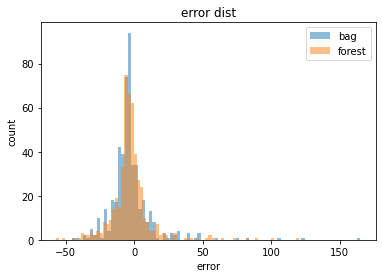

In [16]:
#visualization to see if it looks like it matches

#error=error.reshape(error.shape[0]*error.shape[1],1)
x_ax = range(len(y_test))
plt.tight_layout()
fig1 = plt.gcf()
plt.hist(bagerror, bins='auto', alpha=.5, label='bag')
plt.hist(foresterror, bins='auto', alpha=.5, label='forest')
plt.title('error dist')
plt.xlabel('error')
plt.ylabel('count')
plt.legend()
plt.show()

#create a graph called stats.png
fig1.savefig('stats.png', dpi=100)

In [34]:
from pyparsing import results
testmincorr=[.1,.15,.2,.22,.24]
col=["mincorr","#features","bag_mae_std", "bag_mae_mean", "forest_mae_std", "forest_mae_mean"]
df=pd.DataFrame(columns=col)
bags=[]
forests=[]
for n in testmincorr:
  x,y,test1=getData()
  x, test1=removeFeatures(x,y,test1,n)
  features=int(len(x.columns))
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
  hyperbag={'n_estimators': [75,85,90],'max_features':[4,5]}
  bagparam,results=getParams(x_train, y_train, BaggingRegressor, hyperbag)
  hyperbag={'n_estimators': [75,85,175],'max_features':[4,5,6]}
  forestparam, results=getParams(x_train, y_train, RandomForestRegressor, hyperbag)
  bag = BaggingRegressor(n_estimators=bagparam['n_estimators'],
                       max_features= bagparam['max_features'])
  forest=RandomForestRegressor(max_features=forestparam['max_features'],
                             n_estimators=forestparam['n_estimators'])
  bags.append(bag)
  forests.append(forest)
  bagstd, bagmean=kFoldValues(x,y,bag, kfoldruns)
  foreststd, forestmean=kFoldValues(x,y,forest, kfoldruns)
  df.loc[len(df)]=[n,features,bagstd,bagmean,foreststd,forestmean]
df


Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 85}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 6, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[15.30133053 15.22018423 15.89141888 14.34412117 15.77346373 14.54503878
 14.78252924 16.06384131 15.67215579 13.74773217 14.30833872 15.84245789
 15.91300905 14.76535014 15.25837885 14.37848255 14.11745314 15.05297269
 13.92859567 14.03698906]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[15.3235348  12.48296703 14.29115385 13.98377289 13.36498168 13.31142857
 13.0364652  13.94108059 13.59657509 13.64681319 12.98811355 12.87276557
 13.02404762 12.96474359 14.19626374 13.32322344 13.57399267 13.47968864
 12.88032967 14.82923077]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 4, 'n_estimators': 85}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[13.61608705 14.94944362 13.88776661 13.32696348 14.39619155 13.82754467
 14.01036711 14.60709376 14.5223252  13.54492124 14.05595823 14.5911303
 13.99980931 14.09132456 12.5059503  16.07929168 15.37785178 13.54557746
 13.44093407 13.93462808]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[14.14967033 12.3479304  12.9460989  13.36080586 13.73318681 12.17404762
 14.01172161 12.11040293 13.5478022  12.99619048 13.7359707  12.93320513
 12.3389011  13.97591575 12.46472527 13.59049451 11.5432967  13.80738095
 13.13811355 13.54886447]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 85}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 85}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[12.71236306 13.10906593 13.71851271 12.09574715 12.70353116 14.40253717
 12.54541855 13.77662411 12.88193577 12.70211161 13.19961942 14.17317846
 12.88815415 13.80904977 11.77888386 13.36961862 13.73567019 12.25003313
 13.39412303 12.68852295]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[12.39234001 13.39166128 12.17572721 13.45795087 12.57971881 14.29201681
 12.84469942 12.45976083 12.19707498 13.92729476 11.93191661 14.4427925
 11.98201357 13.12073368 10.60648028 15.15021008 12.94322883 12.76981254
 13.1864415  12.26921461]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
statio

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 75}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 4, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[14.65739021 13.58457875 12.2230232  13.46009158 12.91612943 14.31250611
 13.19663004 14.35228236 14.42804029 11.80911538 14.10203144 13.90163004
 11.92102747 16.62674267 13.12688645 14.03671006 13.4797619  13.83983516
 14.32924603 12.44035562]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[15.97970696 12.17322344 14.02554945 13.59184982 13.3017033  13.92249084
 14.25304029 13.22712454 13.99241758 12.65882784 13.99985348 13.19877289
 14.29122711 12.59820513 13.90591575 13.09007326 12.97168498 13.3540293
 13.87179487 13.25880952]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
statio

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 75}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 4, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[12.05885531 13.27758242 12.28776007 11.97587454 12.59225275 11.20619902
 12.83954396 10.81258242 12.49074664 13.91557326 12.56884005 12.01456044
 12.84598352 12.90358974 11.21683761 13.73436813 12.28869963 12.83428724
 13.62385104 11.26715201]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[12.90456044 12.28950549 12.94294872 12.38716117 12.90102564 11.92111722
 11.76663004 13.95846154 13.35576923 13.25408425 13.27813187 11.59448718
 13.41818681 11.53467033 13.50877289 12.41815018 13.7989011  13.11653846
 15.17238095 11.15617216]


,mincorr,#features,bag_mae_std,bag_mae_mean,forest_mae_std,forest_mae_mean
0,0.10,20.0,0.731416,14.947192,0.688956,13.555559
1,0.15,15.0,0.762266,14.115558,0.727273,13.122736
2,0.20,13.0,0.681025,13.096735,1.003804,12.906054
3,0.22,10.0,1.079106,13.637201,0.789747,13.583315
4,0.24,8.0,0.846258,12.437757,0.945745,12.833883


In [40]:
bag_index=df[['bag_mae_mean']].idxmin()
forest_index=df[['forest_mae_mean']].idxmin()
if float(df.iloc[bag_index]['bag_mae_mean'])< float(df.iloc[forest_index]['forest_mae_mean']):
  #use min corr and model of index
  minCorr=float(df.iloc[bag_index]['mincorr'])
  model=bags[int(bag_index)]
else:
   minCorr=float(df.iloc[forest_index]['mincorr'])
   model=forests[int(forest_index)]

In [41]:
x,y,test=getData()
x, test=removeFeatures(x,y,test,minCorr)
model.fit(x,y)



Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(max_features=5, n_estimators=75)

In [44]:
#submit predictions fo test

#first convert float array to int
pred = model.predict(test)
pred=[int(round(num)) for num in pred]
test_original =pd.read_csv('test.csv')
#test_original =pd.read_csv('dengue_features_test.csv')
#then make data frame for predicted data
submission=pd.DataFrame()
submission[['city', 'year', 'weekofyear']]=test_original[['city', 'year', 'weekofyear']]
submission['total_cases']=pred
#submission.sort_values(["city","year","weekofyear"],axis=0, ascending=True, inplace=True, na_position='first')
submission.to_csv('submission.csv', index=False)